In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-11-26 21:01:07.912532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 21:01:08.079500: I tensorflow/core/tpu/tpu_initializer_helper.cc:262] Libtpu path is: libtpu.so
I1126 21:01:08.195682432   67064 ev_epoll1_linux.cc:121]     grpc epoll fd: 70
D1126 21:01:08.195715339   67064 ev_posix.cc:141]            Using polling engine: epoll1
D1126 21:01:08.195748252   67064 lb_policy_registry.cc:43]   registering LB policy factory for "grpclb"
D1126 21:01:08.195756936   67064 lb_policy_registry.cc:43]   registering LB policy factory for "rls_experimental"
D1126 21:01:08.195771003   67064 lb_policy_registry.cc:43]   registering LB policy factory for "priority_experimental"
D1126 21:01:08

In [3]:
tf.config.list_logical_devices('TPU')

2022-11-26 21:01:10.298663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 21:01:16.646872: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x6cb4da0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-11-26 21:01:16.646904: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): TPU, 2a886c8
2022-11-26 21:01:16.646912: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): TPU, 2a886c8
2022-11-26 21:01:16.646931: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): TPU, 2a886c8
2022-11-26 21:01:16.646936: I tensorflow/compiler/xla/service/service.cc:181]   

[LogicalDevice(name='/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/device:TPU:7', device_type='TPU')]

In [4]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [5]:
batch_size = 64
img_height = 240
img_width = 240
data_dir = os.path.join('data','UPENN-GBM','slice_classification_common_stratify_3channel','train')


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode="rgb",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 49725 files belonging to 5 classes.
Using 39780 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode="rgb",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 49725 files belonging to 5 classes.
Using 9945 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['background', 'background_edema', 'background_edema_contrast', 'background_tumour_edema', 'background_tumour_edema_contrast']


In [9]:
 # Calculate class weights ofr weighting accuracy
ds_classes = []
for _, batch_classes in train_ds:
    ds_classes.append(batch_classes.numpy())

ds_classes = np.concatenate(ds_classes)

class_weight = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(ds_classes),
    y=ds_classes
)

class_weight = dict(zip(np.unique(ds_classes), class_weight))


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./(2**8-1))

In [12]:
num_classes = len(class_names)

In [13]:
margin = 8
scaled_height = img_height - 2*margin
scaled_width = img_width - 2*margin

In [14]:
# Build layers for model


In [15]:

with strategy.scope():
    crop_layer = tf.keras.layers.Cropping2D(margin)
    rescale_initial = tf.keras.layers.Rescaling(1./127.5, offset=-1)
    #conv_4to3_channel = tf.keras.layers.Conv2D(3,1,padding='same', activation='tanh')
    trained_base_model = tf.keras.applications.MobileNetV2(
        input_shape=(scaled_width,scaled_height,3),
        include_top=False,
        weights='imagenet'
    )
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(num_classes)

    trained_base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(img_width, img_height, 3))
    x = crop_layer(inputs)
    x = rescale_initial(x)
    #x = conv_4to3_channel(x)
    x = trained_base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
   
    model_fixed_base = tf.keras.Model(inputs, outputs)
    model_fixed_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
    )

2022-11-26 21:01:41.535057: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-26 21:01:41.595139: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [16]:
model_fixed_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 cropping2d (Cropping2D)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [17]:
small_model_epochs=40
history_model_fixed_base = model_fixed_base.fit(
  train_ds,
  validation_data=val_ds,
  epochs=small_model_epochs,
  class_weight=class_weight
)

2022-11-26 21:02:02.143283: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 39780
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 1/40


2022-11-26 21:02:08.277008: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:9310430552767658238
2022-11-26 21:02:08.558547: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-26 21:02:08.851919: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-26 21:02:12.342639: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(3385615333023655199), session_name()


  4/622 [..............................] - ETA: 27s - loss: 2.4539 - accuracy: 0.2852   

2022-11-26 21:02:16.083639: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 3385615333023655199 with session name  took 3.740911305s and succeeded
2022-11-26 21:02:16.101353: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(3385615333023655199), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_9310430552767658238", property.function_library_fingerprint = 10567142977604041484, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "8,240,240,3,;8,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-26 21:02:16.101410: I tensorflow

 86/622 [===>..........................] - ETA: 16s - loss: 1.7790 - accuracy: 0.2929

2022-11-26 21:02:18.807906: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(4949885541017157960), session_name()


 92/622 [===>..........................] - ETA: 41s - loss: 1.8198 - accuracy: 0.2937

2022-11-26 21:02:23.017205: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 4949885541017157960 with session name  took 4.209221275s and succeeded
2022-11-26 21:02:23.032391: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(4949885541017157960), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_9310430552767658238", property.function_library_fingerprint = 10567142977604041484, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "5,240,240,3,;5,;5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-26 21:02:23.032442: I tensorflow

621/622 [============================>.] - ETA: 0s - loss: 1.5716 - accuracy: 0.3816

2022-11-26 21:02:38.348276: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 9945
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-11-26 

622/622 [==============================] - 50s 60ms/step - loss: 1.5710 - accuracy: 0.3816 - val_loss: 1.2650 - val_accuracy: 0.4978


2022-11-26 21:02:53.215031: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 16861806487957520666 with session name  took 3.711329165s and succeeded
2022-11-26 21:02:53.231392: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(16861806487957520666), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_11426541024698501072", property.function_library_fingerprint = 16019940331598834773, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "4,240,240,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-26 21:02:53.231443: I tensorflow/

Epoch 2/40
622/622 [==============================] - 23s 36ms/step - loss: 1.4052 - accuracy: 0.4510 - val_loss: 1.2781 - val_accuracy: 0.4644
Epoch 3/40
622/622 [==============================] - 23s 37ms/step - loss: 1.3491 - accuracy: 0.4762 - val_loss: 1.1173 - val_accuracy: 0.5933
Epoch 4/40
622/622 [==============================] - 22s 36ms/step - loss: 1.3143 - accuracy: 0.4952 - val_loss: 1.1994 - val_accuracy: 0.5176
Epoch 5/40
622/622 [==============================] - 22s 35ms/step - loss: 1.2743 - accuracy: 0.5095 - val_loss: 1.0878 - val_accuracy: 0.5906
Epoch 6/40
622/622 [==============================] - 21s 34ms/step - loss: 1.2565 - accuracy: 0.5173 - val_loss: 1.0839 - val_accuracy: 0.5927
Epoch 7/40
622/622 [==============================] - 21s 34ms/step - loss: 1.2342 - accuracy: 0.5274 - val_loss: 1.1180 - val_accuracy: 0.5438
Epoch 8/40
622/622 [==============================] - 22s 35ms/step - loss: 1.2147 - accuracy: 0.5363 - val_loss: 1.1323 - val_accuracy:

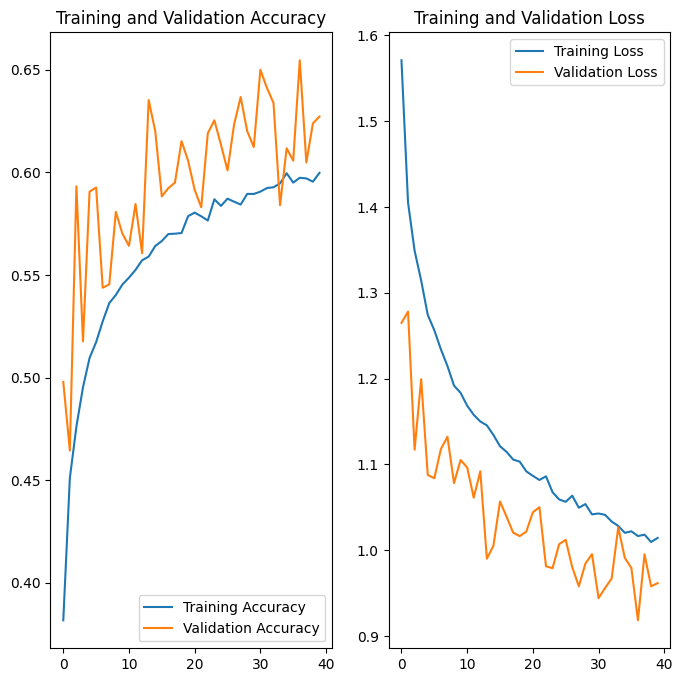

In [25]:
acc = history_model_fixed_base.history['accuracy']
val_acc = history_model_fixed_base.history['val_accuracy']

loss = history_model_fixed_base.history['loss']
val_loss = history_model_fixed_base.history['val_loss']

epochs_range = range(small_model_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
trained_base_model.trainable = True

In [20]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in trained_base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [21]:
with strategy.scope():
  model_fixed_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
  )

In [22]:
model_fixed_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 cropping2d (Cropping2D)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [23]:
fine_tuning_epochs=80
total_epochs = small_model_epochs + fine_tuning_epochs
history_fine_tuning = model_fixed_base.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epochs,
  initial_epoch=history_model_fixed_base.epoch[-1],
  class_weight=class_weight,
)

2022-11-26 21:17:11.468143: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 39780
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 40/120


2022-11-26 21:17:21.047027: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:6827512776956189194
2022-11-26 21:17:21.501389: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-26 21:17:21.910177: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-26 21:17:22.575158: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(14945886638922767293), session_name()


  5/622 [..............................] - ETA: 20s - loss: 0.8577 - accuracy: 0.6375   

2022-11-26 21:17:28.827279: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 14945886638922767293 with session name  took 6.251989463s and succeeded
2022-11-26 21:17:28.859920: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(14945886638922767293), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_6827512776956189194", property.function_library_fingerprint = 6796667587271004529, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "8,240,240,3,;8,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-26 21:17:28.859983: I tensorflo

170/622 [=======>......................] - ETA: 14s - loss: 1.0752 - accuracy: 0.5928

2022-11-26 21:17:34.388579: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(12752041661908486558), session_name()


174/622 [=======>......................] - ETA: 32s - loss: 1.0752 - accuracy: 0.5934

2022-11-26 21:17:41.265602: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 12752041661908486558 with session name  took 6.876923402s and succeeded
2022-11-26 21:17:41.297064: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(12752041661908486558), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_6827512776956189194", property.function_library_fingerprint = 6796667587271004529, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "5,240,240,3,;5,;5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-26 21:17:41.297136: I tensorflo

622/622 [==============================] - ETA: 0s - loss: 1.0558 - accuracy: 0.5934

2022-11-26 21:17:54.943099: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 9945
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-11-26 

622/622 [==============================] - 49s 53ms/step - loss: 1.0558 - accuracy: 0.5934 - val_loss: 1.1203 - val_accuracy: 0.5476
Epoch 41/120
622/622 [==============================] - 23s 38ms/step - loss: 0.9187 - accuracy: 0.6338 - val_loss: 0.9572 - val_accuracy: 0.6066
Epoch 42/120
622/622 [==============================] - 23s 38ms/step - loss: 0.8573 - accuracy: 0.6520 - val_loss: 0.7988 - val_accuracy: 0.6626
Epoch 43/120
622/622 [==============================] - 24s 38ms/step - loss: 0.7795 - accuracy: 0.6714 - val_loss: 0.7806 - val_accuracy: 0.6735
Epoch 44/120
622/622 [==============================] - 24s 38ms/step - loss: 0.7298 - accuracy: 0.6877 - val_loss: 0.7720 - val_accuracy: 0.6778
Epoch 45/120
622/622 [==============================] - 24s 38ms/step - loss: 0.6726 - accuracy: 0.7010 - val_loss: 0.6853 - val_accuracy: 0.7324
Epoch 46/120
622/622 [==============================] - 23s 38ms/step - loss: 0.6217 - accuracy: 0.7194 - val_loss: 0.7175 - val_accuracy

ValueError: x and y must have same first dimension, but have shapes (120,) and (121,)

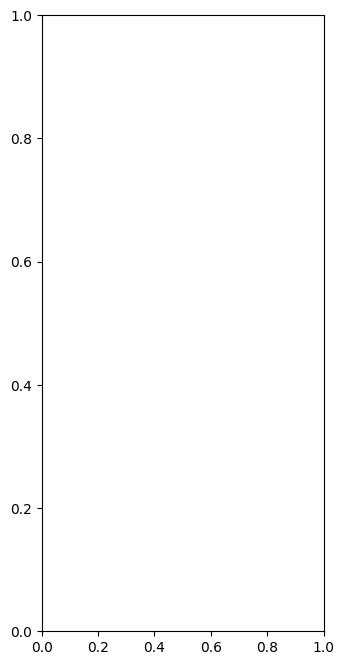

In [26]:
acc += history_fine_tuning.history['accuracy']
val_acc += history_fine_tuning.history['val_accuracy']

loss += history_fine_tuning.history['loss']
val_loss += history_fine_tuning.history['val_loss']

epochs_range = range(total_epochs) 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  4)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)



In [ ]:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    #with tf.device('/CPU:0'):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
aug_ds = aug_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


In [ ]:
with strategy.scope():
    augmented_model = Sequential([
      layers.Rescaling(1./(2**8-1), input_shape=(img_height,
                                  img_width,
                                  4)),
      layers.Conv2D(8, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes, name="outputs")
    ])

    augmented_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [ ]:
augmented_model_epochs = 200
augmented_model_history = augmented_model.fit(
  aug_ds,
  validation_data=val_ds,
  epochs=augmented_model_epochs,
  class_weight=class_weight
)

In [ ]:
acc = augmented_model_history.history['accuracy']
val_acc = augmented_model_history.history['val_accuracy']

loss = augmented_model_history.history['loss']
val_loss = augmented_model_history.history['val_loss']

epochs_range = range(augmented_model_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()